<a href="https://colab.research.google.com/github/AlkaidCheng/GSOC_MLHEP/blob/master/examples/Variational_Quantum_Classifier_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Quantum Classifier
- Step 1: Prepare training data and perform data preprocessing
- Step 2: Construct encoding circuit
- Step 3: Construct variational circuit
- Step 4: Build the VQC model with the encoding circuit as input layer, variational circuit as pqc layer and an output layer with a custom activation function
- Step 5: Decide on the optimizer, the loss function, the evaluation metrics and callbacks for training
- Step 6: Train the classifier
- Step 7: Evaluate the result

###Install dependencies

In [1]:
#this will also install tensorflow==2.1.0 and tensorflow_quantum
!pip install  quple

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 1.4MB 6.4MB/s 
     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 3.9MB 46.2MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 450kB 26.3MB/s 
     |████████████████████████████████| 3.9MB 39.0MB/s 
     |████████████████████████████████| 163kB 35.7MB/s 
     |████████████████████████████████| 112kB 48.7MB/s 
     |████████████████████████████████| 133kB 49.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=eb9c1b2aac90894316e3d2fc9975d0407827ef92f1766006e7cbb33b065e90d8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for pathos: filename=pathos-0.2.5-cp36-none-any.whl size=77577 sha256=9ee0e57c0eea6986b6d45ff1d1d14d4b0797f9600a18795dd4c515743322fcb0
  Stored in directory: /root/.cache/pip/w

 ## Step 1: Prepare Training Data and Perform Data Preprocessing

In [2]:
# download training data (hmumu 2jet)
!wget -O hmumu_2jet.tar.gz https://cernbox.cern.ch/index.php/s/frrpvyVfSPYdMSk/download
!tar -zxf hmumu_2jet.tar.gz

--2020-08-31 20:21:42--  https://cernbox.cern.ch/index.php/s/frrpvyVfSPYdMSk/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.32.38, 188.184.97.72, 128.142.32.26
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.32.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1648491 (1.6M) [application/gzip]
Saving to: ‘hmumu_2jet.tar.gz’

hmumu_2jet.tar.gz   100%[===================>]   1.57M  2.36MB/s    in 0.7s    

Last-modified header invalid -- time-stamp ignored.
2020-08-31 20:21:44 (2.36 MB/s) - ‘hmumu_2jet.tar.gz’ saved [1648491/1648491]



In [3]:
import numpy as np
# prepare training data
data = np.load('hmumu_twojet_0719.npy')
x = data[:,:-1]
y = data[:,-1]
print('x:\n', x)
print('y:\n', y)

x:
 [[ 1.35123826e+02  9.97897017e-01  9.58638570e-01 ...  4.58769383e-01
  -3.05654504e+00  1.80854129e+03]
 [ 2.43290406e+02  3.03747750e-01  6.74568519e-01 ... -1.34468994e+00
  -2.72506172e+00  5.11933555e+02]
 [ 1.64464537e+02 -5.81922591e-02  5.42151745e-02 ... -6.23148328e-01
   3.07514485e+00  3.44958465e+02]
 ...
 [ 2.16542712e+01 -3.05524425e+00  4.59151309e-01 ...  9.26630829e-01
   3.08020790e+00  5.62347204e+02]
 [ 4.19387585e+01  1.89239955e+00  4.48033832e-01 ...  1.73410377e+00
  -2.62992120e+00  1.44320990e+02]
 [ 9.33202609e+01  8.70685882e-01  8.74988118e-01 ... -1.21892943e+00
   2.85587492e+00  2.03240716e+02]]
y:
 [1. 1. 1. ... 0. 0. 0.]


In [4]:
# let's say we want to train on a circuit with 5 qubit
n_qubit = 5
# let's say we want to train on 1000 events
n_event = 1000

In [5]:
# prepare data preprocessors from sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
# we apply 3 data preprocessors
# 1. PCA to reduce the dimension to 5 to fit the 5 qubit circuit
# 2. StandardScaler to standardize features by removing the mean and scaling to unit variance
# 3. MinMaxScaler to bound the data in the range [-1,+1]
preprocessors = [PCA(n_components=n_qubit, random_state=3), StandardScaler(), MinMaxScaler((-1,1))]

In [6]:
from quple.components.data_preparation import prepare_train_val_test
# split the data into training set, validation set and test set
x_train, x_val, x_test, y_train, y_val, y_test = prepare_train_val_test(x, y, train_size=n_event, val_size=n_event, test_size=n_event, preprocessors=preprocessors, random_state=24)
print('x_train:\n', x_train)
print('y_train:\n', y_train)
print('x_val:\n', x_val)
print('y_val:\n', y_val)
print('x_test:\n', x_test)
print('y_test:\n', y_test)

x_train:
 [[-8.79408431e-01 -2.91849404e-01 -7.06406980e-01 -1.50171968e-01
  -1.47083778e-01]
 [-6.85069866e-01 -5.15238276e-01 -7.45426413e-01 -1.49557330e-01
  -2.77217974e-01]
 [-9.65548075e-01 -5.41138509e-01 -7.17157856e-01  5.28963334e-02
  -2.94952005e-01]
 ...
 [-8.05304035e-01 -5.60343372e-01 -7.32252537e-01  1.18326216e-01
  -3.20379264e-01]
 [-8.28134277e-01 -5.54357138e-01 -4.72595477e-01  1.14451725e-01
  -2.63482577e-01]
 [-9.30681340e-01 -7.04202429e-01 -5.31064503e-01 -5.78536766e-04
  -2.29519358e-01]]
y_train:
 [1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 0

## Step 2: Construct Encoding Circuit

In [7]:
from quple.data_encoding import FirstOrderPauliZEncoding, SecondOrderPauliZEncoding
from quple.data_encoding.encoding_maps import self_product, cosine_product, modified_cosine_product, distance_measure, arithmetic_mean

In [8]:
# let's try the first order pauli z encoding circuit with depth 2
encoding_circuit = FirstOrderPauliZEncoding(feature_dimension=n_qubit, copies=2)
encoding_circuit

(0, 0): ───H───Rz(pi*x_0)───H───Rz(pi*x_0)───

(0, 1): ───H───Rz(pi*x_1)───H───Rz(pi*x_1)───

(0, 2): ───H───Rz(pi*x_2)───H───Rz(pi*x_2)───

(0, 3): ───H───Rz(pi*x_3)───H───Rz(pi*x_3)───

(0, 4): ───H───Rz(pi*x_4)───H───Rz(pi*x_4)───

## Step 3: Construct Variational Circuit

In [9]:
from quple.circuits.variational_circuits import EfficientSU2

In [10]:
# let's try the Efficient SU2 variational circuit with depth 2
variational_circuit = EfficientSU2(n_qubit=n_qubit, copies=2)
variational_circuit.add_readout('XX')
variational_circuit

┌──┐       ┌──┐                                                ┌──┐       ┌──┐
(-1, -1): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────XX──────────XX──────────XX──────────XX──────────XX──────────
                                                                                                                                                        │           │           │           │           │
(0, 0): ─────Ry(θ_0)───Rz(θ_5)───@───@───@────@────────────────────Ry(θ_10)───Rz(θ_15)───@──────────@───@────@────────────────────Ry(θ_20)───Rz(θ_25)───XX^(θ_30)───┼───────────┼───────────┼───────────┼───────────
                                 │   │   │    │                                          │          │   │    │                                                      │           │           │           │
(0, 1): ─────Ry(θ_1)───Rz(θ_6)───X───┼───┼────┼@────@────@─────────Ry(θ_11)───Rz(θ_16)───X──────────┼───┼────┼@────@────@─────────Ry(θ_21)───Rz(θ_26)───────────────XX^(θ_31)───┼───────────┼───────────┼───────────
                                     │   │    ││    │    │                                          │   │    ││    │    │                                                       │           │           │
(0, 2): ─────Ry(θ_2)───Rz(θ_7)───────X───┼────┼X────┼────┼@────@───Ry(θ_12)───Rz(θ_17)──────────────X───┼────┼X────┼────┼@────@───Ry(θ_22)───Rz(θ_27)───────────────────────────XX^(θ_32)───┼───────────┼───────────
                                         │    │     │    ││    │                                        │    │     │    ││    │                                                             │           │
(0, 3): ─────Ry(θ_3)───Rz(θ_8)───────────X────┼─────X────┼X────┼───@──────────Ry(θ_13)───Rz(θ_18)───────X────┼─────X────┼X────┼───@──────────Ry(θ_23)───Rz(θ_28)────────────────────────────XX^(θ_33)───┼───────────
                                              │          │     │   │                                         │          │     │   │                                                                     │
(0, 4): ─────Ry(θ_4)───Rz(θ_9)────────────────X──────────X─────X───X──────────Ry(θ_14)───Rz(θ_19)────────────X──────────X─────X───X──────────Ry(θ_24)───Rz(θ_29)────────────────────────────────────────XX^(θ_34)───
                                             └──┘       └──┘                                                └──┘       └──┘

## Step 4 and 5: Build the VQC Model

In [11]:
from quple.classifiers import VQC
import tensorflow as tf

In [12]:
# let's use the following settings
# output layer activation = sigmoid
# optimizer = Adam
# metrics = binary accuracy and auc
# loss = mean squared loss

# construct the vqc model
vqc = VQC(encoding_circuit, variational_circuit,
          activation='sigmoid',
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
          metrics=['binary_accuracy','AUC'],
          readout=[variational_circuit.gate_operation('Z', variational_circuit.readout_qubit)],
          loss='mse',
          random_state=16)

Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35


## Step 6: Train the Classifier

In [13]:
# train the vqc moel
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
vqc.fit(x_train, y_train,
        batch_size=64,
        epochs=10,
        verbose=1,
        validation_data=(x_val, y_val),
        callbacks=[callback])

Converting circuits to tensors...
Converting circuits to tensors...


Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 19s 19ms/sample - loss: 0.2408 - binary_accuracy: 0.6170 - AUC: 0.6542 - val_loss: 0.2281 - val_binary_accuracy: 0.6820 - val_AUC: 0.7968
Epoch 2/10
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.2253 - binary_accuracy: 0.6780 - AUC: 0.7653 - val_loss: 0.2165 - val_binary_accuracy: 0.7000 - val_AUC: 0.8206
Epoch 3/10
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.2142 - binary_accuracy: 0.6990 - AUC: 0.8132 - val_loss: 0.2070 - val_binary_accuracy: 0.7230 - val_AUC: 0.8427
Epoch 4/10
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.2073 - binary_accuracy: 0.7380 - AUC: 0.8351 - val_loss: 0.2018 - val_binary_accuracy: 0.7450 - val_AUC: 0.8533
Epoch 5/10
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.2028 - binary_accuracy: 0.7310 - AUC: 0.8416 - val_loss: 0.1991 - val_binary_accuracy: 0.7380 

## Step 7: Evaluate the Result

In [14]:
# test the model
results = vqc.evaluate(x_test, y_test)
results

Converting circuits to tensors...


1000/1000 [==============================] - 1s 1ms/sample - loss: 0.1928 - binary_accuracy: 0.7540 - AUC: 0.8693


[0.19279021203517913, 0.754, 0.8693333]

Converting circuits to tensors...


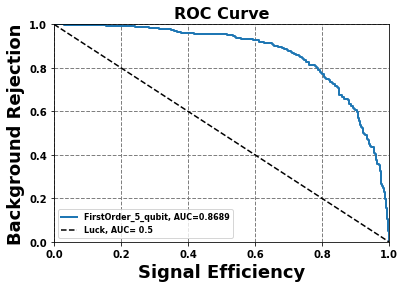

In [17]:
import quple
# plot a roc curve
fpr, tpr, _, _ = vqc.roc_curve(x_test, y_test)
plt = quple.utils.utils.plot_roc_curve(fpr, tpr, label='FirstOrder_5_qubit', title='ROC Curve')

## Try Different Encoding Circuits

In [20]:
# Try out different encoding maps and using SecondOrderExpansion encoding circuit
# encoding map = self_product ~ x_0*x_1*x_2...
second_order_self_product = SecondOrderPauliZEncoding(feature_dimension=n_qubit, entangle_strategy='linear')
print(second_order_self_product)

(0, 0): ───H───Rz(pi*x_0)───@──────────────────────@────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@───────────────────────────────@────────────────────────────────────────────────────────────────────────────────────
                            │                      │                                                                                                 │                               │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<x_0*x_1>)───X───@──────────────────────@─────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<x_0*x_1>)───X───@──────────────────────@─────────────────────────────────────────────────────────
                                                       │                      │                                                                                                          │                      │
(0, 2): ───H───Rz(pi*x_2)──────────────────────────────X───Rz(pi*<x_1*x_2

In [21]:
# encoding map = cosine_product ~ cos(x_0)*cos(x_1)*...
second_order_cosine_product = SecondOrderPauliZEncoding(feature_dimension=n_qubit, encoding_map=cosine_product, entangle_strategy='linear')
print(second_order_cosine_product)

(0, 0): ───H───Rz(pi*x_0)───@────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@─────────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                            │                                │                                                                                                                               │                                         │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<cos(x_0)*cos(x_1)>)───X───@────────────────────────────────@─────────────────────────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<cos(x_0)*cos(x_1)>)───X───@────────────────────────────────@─────────────────────────────────────────────────────────────────────────────
                                                                 │       

In [22]:
# encoding map = distance_measure ~ (x_0-x_1)*(x_1-x_2)*(x_2-x_3)/2**(number of pairs)...
second_order_distance_measure = SecondOrderPauliZEncoding(feature_dimension=n_qubit, encoding_map=distance_measure, entangle_strategy='linear')
print(second_order_distance_measure)

(0, 0): ───H───Rz(pi*x_0)───@────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@─────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────
                            │                            │                                                                                                                   │                                     │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<x_0/2 - x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<x_0/2 - x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────────
                                                             │                            │                                                                  

In [23]:
# encoding map = arithmetic_mean ~ (x_0+x_1+x_2+...)/N...
second_order_arithmetic_mean = SecondOrderPauliZEncoding(feature_dimension=n_qubit, encoding_map=arithmetic_mean, entangle_strategy='linear')
print(second_order_arithmetic_mean)

(0, 0): ───H───Rz(pi*x_0)───@────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@─────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────
                            │                            │                                                                                                                   │                                     │
(0, 1): ───H───Rz(pi*x_1)───X───Rz(pi*<x_0/2 + x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────H───Rz(pi*x_1)───X────────────Rz(pi*<x_0/2 + x_1/2>)───X───@────────────────────────────@─────────────────────────────────────────────────────────────────────
                                                             │                            │                                                                  

In [24]:
# construct the models with the various encoding circuits
my_models = [
  VQC(second_order_self_product, variational_circuit, metrics=['binary_accuracy','AUC'], loss='mse', readout=[second_order_self_product.gate_operation('Z', variational_circuit.readout_qubit)], random_state=16),
  VQC(second_order_cosine_product, variational_circuit, metrics=['binary_accuracy','AUC'], loss='mse', readout=[second_order_cosine_product.gate_operation('Z', variational_circuit.readout_qubit)], random_state=16),
  VQC(second_order_distance_measure, variational_circuit, metrics=['binary_accuracy','AUC'], loss='mse', readout=[second_order_distance_measure.gate_operation('Z', variational_circuit.readout_qubit)], random_state=16),
  VQC(second_order_arithmetic_mean, variational_circuit, metrics=['binary_accuracy','AUC'], loss='mse', readout=[second_order_arithmetic_mean.gate_operation('Z', variational_circuit.readout_qubit)], random_state=16)
]

Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35
Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 35


In [25]:
# create the tensor form of the resolved encoding circuits (this can be feeded to model.fit directly so that the conversion does not happen inside fit)
x_train_tensors = [model.convert_to_tensor(x_train) for model in my_models]
x_val_tensors = [model.convert_to_tensor(x_val) for model in my_models]
x_test_tensors = [model.convert_to_tensor(x_test) for model in my_models]

Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...
Converting circuits to tensors...


In [26]:
# train the models
# you may increase the number of epochs if it did not converge 
for i,model in enumerate(my_models):
  model.fit(
    x_train_tensors[i], y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val_tensors[i], y_val),
    callbacks=[callback])

Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 24s 24ms/sample - loss: 0.2437 - binary_accuracy: 0.5990 - AUC: 0.6285 - val_loss: 0.2403 - val_binary_accuracy: 0.6350 - val_AUC: 0.6842
Epoch 2/10
1000/1000 [==============================] - 23s 23ms/sample - loss: 0.2406 - binary_accuracy: 0.6160 - AUC: 0.6670 - val_loss: 0.2373 - val_binary_accuracy: 0.6520 - val_AUC: 0.7072
Epoch 3/10
1000/1000 [==============================] - 24s 24ms/sample - loss: 0.2377 - binary_accuracy: 0.6320 - AUC: 0.6888 - val_loss: 0.2344 - val_binary_accuracy: 0.6650 - val_AUC: 0.7216
Epoch 4/10
1000/1000 [==============================] - 24s 24ms/sample - loss: 0.2350 - binary_accuracy: 0.6400 - AUC: 0.7024 - val_loss: 0.2317 - val_binary_accuracy: 0.6760 - val_AUC: 0.7308
Epoch 5/10
1000/1000 [==============================] - 24s 24ms/sample - loss: 0.2324 - binary_accuracy: 0.6550 - AUC: 0.7130 - val_loss: 0.2293 - val_binary_accuracy: 0.6790 

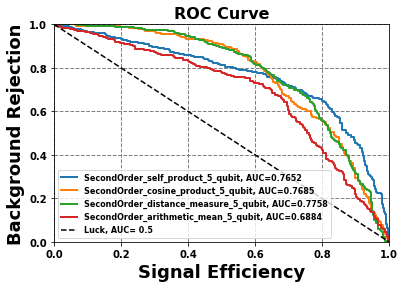

In [28]:
# plot the roc curves
fpr_list, tpr_list = [], []
for i,model in enumerate(my_models):
  fpr, tpr, _, _ = model.roc_curve(x_test_tensors[i], y_test)
  fpr_list.append(fpr)
  tpr_list.append(tpr)
labels = ['SecondOrder_self_product_5_qubit',
          'SecondOrder_cosine_product_5_qubit',
          'SecondOrder_distance_measure_5_qubit',
          'SecondOrder_arithmetic_mean_5_qubit']
multi_model_plt = quple.utils.utils.plot_stacked_roc_curve(fpr_list, tpr_list, labels)